
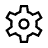


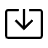


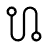


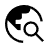


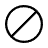


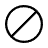


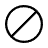


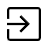


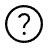


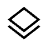


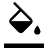


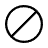


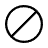


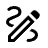


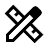


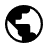

on_create_lines_click triggered
Line Creation Mode: True
Marker clicked!
Location: [44.42111229573958, -1.710297225391271]
Line Creation Mode: True
Selected Points: []
Marker clicked!
Location: [45.10763759028244, 0.7282250229080401]
Line Creation Mode: True
Selected Points: [[44.42111229573958, -1.710297225391271]]


In [1]:
from ipyleaflet import Map, Marker, Polyline, WidgetControl
from ipywidgets import Button
import ipywidgets as widgets
from IPython.display import display, HTML
from ipyleaflet import Map, DrawControl, basemaps
from pathlib import Path
import base64
from geographiclib.geodesic import Geodesic
from ipyleaflet import Marker
from ipyleaflet import CircleMarker
from ipyleaflet import Popup
from ipyleaflet import LayerGroup
from ipyleaflet import DivIcon
from ipyleaflet import Rectangle
from ipyleaflet import Polyline
import os
import numpy as np


custom_css = """
<style>
    .widget-dropdown > select:hover, .widget-dropdown > select:focus {
        background-color: #10a393;  /* or any color of your choice */
    }
</style>
"""

css_line_spacing = """
<style>
    .jupyter-widgets .widget-label, 
    .jupyter-widgets .widget-readout,
    .jupyter-widgets .widget-html-content {
        line-height: 1.3;   /* Adjust this value as per your preference. Default is typically 1.5. */
        font-size: 1.05em;
    }
</style>
"""
display(HTML(css_line_spacing))

# CSS styles for button appearance
css_button_styles = """
<style>
    .custom-button {
        background-color: #1f4b61 !important;
        color: white !important;
        font-weight: bold !important;
        font-size: 1.05em;
        font-family: Segoe UI;
    }
    
    .custom-button:hover {
        background-color: #10a393 !important;
        color: white !important;
        font-size: 1.05em;
    }
    
    .custom-button:active {
        background-color: #10a393 !important;
        color: white !important;
        font-size: 1.05em;
    }
</style>
"""
display(HTML(css_button_styles))

def load_logo(logo_path):
    with open(logo_path, "rb") as f:
        image = f.read()
    return widgets.Image(value=image, format='png', layout=widgets.Layout(width='23%'))

logo_path = "C:/Users/BartekKulig/OneDrive - Hardt/Desktop/Compass/LOGO.png"
logo_widget = load_logo(logo_path)
logo_widget.layout.width = '80%'
logo_widget.layout.margin = '0 auto 30px auto'
logo_widget.layout.display = 'block'

last_button_id = None
draw_control = None

# Add the global variable here
hub_creation_mode = False
point_creation_mode = False  # Add this line
line_creation_mode = False
selected_points = []
all_points = []
line_coordinates = []
# Create lists to keep track of hubs, points, and lines
hubs = []
points = []
lines = []


# Define the draw control and its configurations
draw_control = DrawControl(
    marker={'shapeOptions': {'color': '#1f4b61'}},
    polyline={'shapeOptions': {'color': '#1f4b61'}},
    polygon={'shapeOptions': {'color': '#1f4b61'}},
    rectangle={'shapeOptions': {'color': '#1f4b61'}},
    circlemarker={},
    edit=True,
    remove=True
)

def measure_drawn_shape(shape, map_units):
    if isinstance(shape, dict) and 'type' in shape:
        coordinates = shape['coordinates']
        if shape['type'] == "LineString":  # Measure distance
            distance = 0
            for i in range(len(coordinates) - 1):
                distance += Geodesic.WGS84.Inverse(coordinates[i][1], coordinates[i][0], coordinates[i+1][1], coordinates[i+1][0])["s12"]
            distance /= 1000  # Convert to km
            return f"Distance: {distance:.2f} km"
        elif shape['type'] == "Polygon":  # Measure area
            area = Geodesic.WGS84.Area(coordinates[0])["s12"]
            area /= (1000 * 1000)  # Convert to square km
            return f"Area: {abs(area):.2f} sq.km"
    return ""


# MAP SETTINGS

map_units_dropdown = widgets.Dropdown(
    options=['meters', 'kilometers'],
    value='meters',
    description='Map units:'
)

def on_map_unit_change(change):
    # You can set any logic needed to adjust the map units here
    print(f"Map unit changed to {change['new']}")

map_units_dropdown.observe(on_map_unit_change, names='value')

basemap_choices = {
    'OpenStreetMap Mapnik': basemaps.OpenStreetMap.Mapnik,
    'ESRI Satellite': basemaps.Esri.WorldImagery,
    'Simple Gray': basemaps.CartoDB.Positron  # adding the gray basemap here
}

def on_basemap_change(change):
    global m
    current_center = m.center
    current_zoom = m.zoom
    new_basemap = basemap_choices[change['new']]
    m = Map(center=current_center, zoom=current_zoom, basemap=new_basemap, scroll_wheel_zoom=True, layout=widgets.Layout(width='60%', height='99%'))
    main_display.children = [left_combined, m, right_content, right_column]

basemap_dropdown = widgets.Dropdown(
    options=list(basemap_choices.keys()),
    value='OpenStreetMap Mapnik',
    description='Basemap:'
)
basemap_dropdown.observe(on_basemap_change, names='value')



# PROJECT TOOLS
# Add the components for the "Project Tools"
open_project_btn = widgets.Button(description="Open Project", layout=widgets.Layout(width='150px'))
open_project_btn.add_class('custom-button')
define_boundary_btn = widgets.Button(description="Define boundary", layout=widgets.Layout(width='150px'))
define_boundary_btn.add_class('custom-button')
project_name_input = widgets.Text(value='Input your Project Name...', layout=widgets.Layout(width='450px'))
save_project_btn = widgets.Button(description="Save Project", layout=widgets.Layout(width='150px'))
save_project_btn.add_class('custom-button')
route_name_input = widgets.Text(value='Route Name', layout=widgets.Layout(width='150px'))


# IMPORT TOOLS
# Add the components for the "Project Tools"
import_roads_btn = widgets.Button(description="Import Roads", layout=widgets.Layout(width='150px'))
import_roads_btn.add_class('custom-button')
import_railways_btn = widgets.Button(description="Import Railways", layout=widgets.Layout(width='150px'))
import_railways_btn.add_class('custom-button')
import_buildings_btn = widgets.Button(description="Import Buildings", layout=widgets.Layout(width='150px'))
import_buildings_btn.add_class('custom-button')
import_zoning_btn = widgets.Button(description="Import Zoning", layout=widgets.Layout(width='150px'))
import_zoning_btn.add_class('custom-button')
import_SHP_btn = widgets.Button(description="Import SHP", layout=widgets.Layout(width='150px'))
import_SHP_btn.add_class('custom-button')

# EXPORT
# Add the components for the "Project Tools"
export_pdf_btn = widgets.Button(description="Export PDF", layout=widgets.Layout(width='150px'))
export_pdf_btn.add_class('custom-button')
export_vessel_btn = widgets.Button(description="Export to VESSEL", layout=widgets.Layout(width='150px'))
export_vessel_btn.add_class('custom-button')

hub_choices = {
    'Passenger': basemaps.OpenStreetMap.Mapnik,
    'Cargo': basemaps.Esri.WorldImagery
}

# ROuting
# Add the components for the "Project Tools"
minimum_speed_input = widgets.Text(value='Minimum speed...', layout=widgets.Layout(width='150px'))
create_route_btn = widgets.Button(description="Create Route", layout=widgets.Layout(width='150px'))
create_route_btn.add_class('custom-button')
create_hub_btn = widgets.Button(description="Create Hubs", layout=widgets.Layout(width='150px'))
create_hub_btn.add_class('custom-button')
create_point_btn = widgets.Button(description="Create Points", layout=widgets.Layout(width='150px'))
create_point_btn.add_class('custom-button')
create_lines_btn = widgets.Button(description="Create Lines", layout=widgets.Layout(width='150px'))
create_lines_btn.add_class('custom-button')
create_curves_btn = widgets.Button(description="Create Curves", layout=widgets.Layout(width='150px'))
create_curves_btn.add_class('custom-button')
hub_name_input = widgets.Text(value='Enter Hub Name...', layout=widgets.Layout(width='450px'))
hub_type_dropdown = widgets.Dropdown(
    options=list(hub_choices.keys()),
    value='Passenger',
    description='Hub Type:'
)

# Add Undo and Clear buttons for Hubs, Points, and Lines
undo_hub_btn = widgets.Button(description="", icon="undo", layout=widgets.Layout(width='40px'))
clear_hub_btn = widgets.Button(description="", icon="times", layout=widgets.Layout(width='40px'))

undo_point_btn = widgets.Button(description="", icon="undo", layout=widgets.Layout(width='40px'))
clear_point_btn = widgets.Button(description="", icon="times", layout=widgets.Layout(width='40px'))

undo_line_btn = widgets.Button(description="", icon="undo", layout=widgets.Layout(width='40px'))
clear_line_btn = widgets.Button(description="", icon="times", layout=widgets.Layout(width='40px'))

save_route_btn = widgets.Button(description="Save Route", layout=widgets.Layout(width='150px'))
save_route_btn.add_class('custom-button')

def save_route(button):
    # Placeholder action when button is clicked
    print("Route saved!")

save_route_btn.on_click(save_route)

# Add tooltips for Hubs
undo_hub_btn.tooltip = "Undo"
clear_hub_btn.tooltip = "Clear"

# Add tooltips for Points
undo_point_btn.tooltip = "Undo"
clear_point_btn.tooltip = "Clear"

# Add tooltips for Lines
undo_line_btn.tooltip = "Undo"
clear_line_btn.tooltip = "Clear"

# Define the undo and clear handler functions

def undo_hub_handler(btn):
    if hubs:
        hub_data = hubs.pop()
        marker = hub_data.get("marker", None)
        label = hub_data.get("label", None)

        if marker:
            m.remove_layer(marker)
        
        if label:
            m.remove_layer(label)

def clear_hubs_handler(btn):
    while hubs:
        hub = hubs.pop()
        # If it's a dictionary, it means it has both a marker and a label
        if isinstance(hub, dict):
            m.remove_layer(hub["marker"])
            m.remove_layer(hub["label"])

def undo_point_handler(btn):
    if points:
        point = points.pop()
        m.remove_layer(point)

def clear_points_handler(btn):
    while points:
        point = points.pop()
        m.remove_layer(point)

def undo_line_handler(btn):
    if lines:
        line = lines.pop()
        m.remove_layer(line)

def clear_lines_handler(btn):
    while lines:
        line = lines.pop()
        m.remove_layer(line)

# Connect the buttons to their handlers
undo_hub_btn.on_click(undo_hub_handler)
clear_hub_btn.on_click(clear_hubs_handler)

undo_point_btn.on_click(undo_point_handler)
clear_point_btn.on_click(clear_points_handler)

undo_line_btn.on_click(undo_line_handler)
clear_line_btn.on_click(clear_lines_handler)

# Define behavior for the "Define boundary" button
def define_boundary_handler(btn):
    # Enable rectangle drawing
    draw_control.rectangle = {'shapeOptions': {'color': '#1f4b61'}}
    m.add_control(draw_control)
    m.observe(handle_draw, 'last_draw')

define_boundary_btn.on_click(define_boundary_handler)

message_display = widgets.HTML()  # This is an empty HTML widget for now.

def save_project_handler(btn):
    project_name = project_name_input.value
    if project_name:
        # Define the path to save the project folder
        username = os.getlogin()  # Fetch the current username
        base_path = f"C:/Users/{username}/Hardt/Market Development - 07. Compass tool development/COMPASS/Projects"
        project_path = Path(base_path) / project_name
        
        # Check if the directory already exists
        if project_path.exists():
            message_display.value = f'Directory with name <b>{project_name}</b> already exists in COMPASS workspace.'
        else:
            # Create the directory
            project_path.mkdir(parents=True, exist_ok=True)
            message_display.value = f'Project <b>{project_name}</b> has been saved in COMPASS workspace.'
    else:
        message_display.value = f'Please specify a project name before saving.'

save_project_btn.on_click(save_project_handler)

dropdown_layout = widgets.Layout(height='90%')
basemap_dropdown.layout = dropdown_layout
map_units_dropdown.layout = dropdown_layout

active_left_button = None
active_right_button = None

def set_button_active(button):
    global active_left_button, active_right_button
    # If the button is from the left column
    if button in left_buttons:
        # Deactivate any previously active left button
        if active_left_button:
            active_left_button.remove_class('active')
        # Set the new button as active and update the reference
        button.add_class('active')
        active_left_button = button
    # If the button is from the right column
    elif button in right_buttons:
        # Check if the clicked button is already active
        if button == active_right_button:
            # If it is, deactivate it and nullify the reference
            button.remove_class('active')
            active_right_button = None
        else:
            # If another button is active, deactivate it
            if active_right_button:
                active_right_button.remove_class('active')
            # Set the new button as active and update the reference
            button.add_class('active')
            active_right_button = button

def on_create_route_click(btn):
    if hub_content.layout.display == 'none':
        hub_content.layout.display = 'block'
    else:
        hub_content.layout.display = 'none'

create_route_btn.on_click(on_create_route_click)

def on_create_hub_click(btn):
    global hub_creation_mode
    hub_creation_mode = not hub_creation_mode
    
    # Change button description based on mode
    if hub_creation_mode:
        create_hub_btn.description = "Finish"
    else:
        create_hub_btn.description = "Create Hubs"
        
create_hub_btn.on_click(on_create_hub_click)

def on_create_point_click(btn):
    global point_creation_mode
    point_creation_mode = not point_creation_mode
    
    # Change button description based on mode
    if point_creation_mode:
        create_point_btn.description = "Finish"
    else:
        create_point_btn.description = "Create Points"
        
create_point_btn.on_click(on_create_point_click)

point_to_lines = {}  # Key: Point's location, Value: List of lines connected to this point

def on_create_lines_click(btn):
    print("on_create_lines_click triggered")
    global line_creation_mode
    global point_to_lines  # Add this global reference to access our dictionary
    line_creation_mode = not line_creation_mode
    print("Line Creation Mode:", line_creation_mode)  # Add this line for debugging
    
    # If we're leaving the line creation mode:
    if not line_creation_mode:
        create_lines_btn.description = "Create Lines"

        # Only make the relation when we have exactly two selected points (meaning a line is created)
        if len(selected_points) == 2:
            print("Two points selected. Forming a line.")
            line = Polyline(
                locations=selected_points,
                color="#1f4b61",
                weight=3,
                fill=False
            )
            m.add_layer(line)
            lines.append(line)
            
            # Update point_to_lines dictionary for each selected point
            for pt in selected_points:
                pt_tuple = tuple(pt)  # Convert list to tuple for dictionary key
                if pt_tuple in point_to_lines:
                    point_to_lines[pt_tuple].append(line)
                else:
                    point_to_lines[pt_tuple] = [line]
            print(point_to_lines)  # Debugging statement

        selected_points.clear()
    else:
        create_lines_btn.description = "Finish"
        
create_lines_btn.on_click(on_create_lines_click)

def create_curve_at_intersection(intersection, line1, line2):
    # Constants
    RADIUS = float(minimum_speed_input.value)  # Assuming this is the desired radius
    
    # Function to get normalized direction vector of a line segment
    def get_direction(line):
        start, end = line.locations
        dx = end[1] - start[1]
        dy = end[0] - start[0]
        mag = (dx**2 + dy**2)**0.5
        return (dx/mag, dy/mag)
    
    dir1 = get_direction(line1)
    dir2 = get_direction(line2)
    
    # Compute the bisector direction
    bisector = (dir1[0] + dir2[0], dir1[1] + dir2[1])
    mag = (bisector[0]**2 + bisector[1]**2)**0.5
    bisector = (bisector[0]/mag, bisector[1]/mag)
    
    # Find the center of the circle
    cx = intersection[1] + RADIUS * bisector[0]
    cy = intersection[0] + RADIUS * bisector[1]
    
    # TODO: Compute the start and end points of the arc on the circle
    # This step might require more advanced geometry, especially if the arc doesn't span the entire circle.
    # For the sake of simplicity, I will draw a full circle for now. You can refine this later.
    
    circle = Circle(
        location=(cy, cx),
        radius=RADIUS * 111.32,  # Rough conversion from degrees to kilometers; might need adjustments
        color="#FF0000",
        fill_color="#FF0000",
        fill_opacity=0.5
    )
    m.add_layer(circle)

def calculate_arc_points(A, B, C, radius):
    # Convert the points to numpy arrays for easier vector arithmetic
    A = np.array(A)
    B = np.array(B)
    C = np.array(C)

    # Calculate normalized direction vectors for BA and BC
    BA_normalized = (A - B) / np.linalg.norm(A - B)
    BC_normalized = (C - B) / np.linalg.norm(C - B)

    B1 = B + radius * BA_normalized
    B2 = B + radius * BC_normalized

    return B1.tolist(), B2.tolist()

def is_close(point1, point2, threshold=1e-2):
    """Check if two points are close enough within a threshold."""
    return abs(point1[0] - point2[0]) < threshold and abs(point1[1] - point2[1]) < threshold


def create_curves(btn):
    print("Create curves button clicked!")
    print("Intersections:", [intersection.location for intersection in points])  # Debugging statement

    
    # Iterate through all the intersection points
    for intersection in points:
        lines_connected = point_to_lines.get(tuple(intersection.location), [])

        # Make sure we found exactly 2 lines connected to the intersection
        if len(lines_connected) != 2:
            print(f"Unexpected number of lines ({len(lines_connected)}) connected to intersection point {intersection.location}")
            continue

        line1, line2 = lines_connected
        create_curve_at_intersection(intersection.location, line1, line2)

        
create_curves_btn.on_click(create_curves)

def handle_marker_click(**kwargs):
    global line_creation_mode, selected_points

    # Directly fetch the coordinates from kwargs
    location = kwargs.get('coordinates', None)

    print("Marker clicked!")
    print("Location:", location)
    print("Line Creation Mode:", line_creation_mode)
    print("Selected Points:", selected_points)
    
    if location and line_creation_mode:
        # Check if location is already in selected_points
        if location in selected_points:
            print("This point has already been selected. Please select a different point.")
            return  # Exit the function early without appending the location again
          
        selected_points.append(location)

        # If two points are selected, draw a line
        if len(selected_points) == 2:
            line = Polyline(
                locations=selected_points,
                color="#1f4b61",
                weight=3,
                fill=False
            )
            m.add_layer(line)
            lines.append(line)
            selected_points.clear()  # Clear to start a new line segment


hub_content = widgets.VBox([
    widgets.HTML("<br />"),
    hub_name_input,
    hub_type_dropdown,
    widgets.HBox([create_hub_btn, undo_hub_btn, clear_hub_btn]),
    widgets.HTML("<br />"),
    widgets.HBox([create_point_btn, undo_point_btn, clear_point_btn]),
    widgets.HTML("<i>This will allow you to create intermediate/shape points. After creating consecutive points, they will be automatically connected.</i>"),
    widgets.HTML("<br />"),
    widgets.HBox([create_lines_btn, undo_line_btn, clear_line_btn]),
    widgets.HTML("<i>This will allow you to create lines between points.</i>"),
    widgets.HTML("<br />"),
    create_curves_btn,
    widgets.HTML("<br />"),
    widgets.HTML("<br />"),
    route_name_input,
    save_route_btn,
])

# Initially hide the content
hub_content.layout.display = 'none'

def update_content(button_id):
    global last_button_id, draw_control
    # Added this part
    if 1 <= button_id <= 8:
        button = left_buttons[button_id - 1]
    else:
        button = right_buttons[button_id - 9] # Subtract 9 to index from 0 for the right buttons

    set_button_active(button)
    title, content = button_content_map.get(button_id, ("", ""))
    if 1 <= button_id <= 8:
        target_content = left_content
    else:
        if last_button_id == button_id:
            toggle_right_content()
        else:
            if right_content.layout.visibility == 'hidden':
                toggle_right_content()
        last_button_id = button_id
        target_content = right_content
        
    if button_id == 16:
        title = "Map settings"
        content_widget = widgets.VBox([
            widgets.HTML('<center><b>Coordinate system:</b> EPSG:3857 (Web Mercator)</center>'),
            widgets.HTML("<br />"),   # empty row
            map_units_dropdown,
            widgets.HTML("<br />"),   # empty row
            basemap_dropdown
        ])
    elif button_id == 14:
        title = "Freehand Tool"
        
        # Check if the draw control is already on the map
        if draw_control in m.controls:
            m.remove_control(draw_control)
            content_widget = widgets.HTML('<center>Freehand drawing has been disabled.</center>')
        else:
            m.add_control(draw_control)
            content_widget = widgets.HTML('<center>Freehand drawing has been enabled.<br /> It allows you to draw on the map and save your drawing as a reference.</center>')
    elif button_id == 15:  # Measure Tool
        title = "Measure Tool"

        # Check if the draw control is already on the map
        if draw_control in m.controls:
            m.remove_control(draw_control)
            content_widget = widgets.HTML('<center>Measurement tool has been disabled.</center>')
        else:
            m.add_control(draw_control)
            content_widget = widgets.HTML('<center>Measurement tool has been enabled.<br />Draw a line to measure distance or a polygon to measure area.</center>')
        m.observe(handle_draw, 'last_draw')  # observe the last_draw event
        
    elif button_id == 1:
        title = "Project Tools"
        content_widget = widgets.VBox([
            widgets.HTML("You are not working on any project."),
            open_project_btn,
            widgets.HTML("<br />"),   # empty row
            widgets.HTML("<br />Or, if you want to create a new Project, define a project boundary, specify a name and save it."),
            define_boundary_btn,
            widgets.HTML("<br />"),   # empty row
            project_name_input,
            save_project_btn,
            widgets.HTML("<br />"),   # empty row
            message_display
])
    elif button_id == 2:
        title = "Import Tools"
        content_widget = widgets.VBox([
            widgets.HTML("In COMPASS, you can import different types of data to your project."),
            widgets.HTML("<br />"),   # empty row
            widgets.HTML("<center><b><h3>Import from Web</h3></b></center><i>Please note that you can only import data for the current boundaries of your project.</i>"),
            import_roads_btn,
            import_railways_btn,
            import_buildings_btn,
            import_zoning_btn,
            widgets.HTML("<br />"),   # empty row
            widgets.HTML("<center><b><h3>Import from PC</h3></b></center><i>Please note that you can only import SHP files in .ZIP format for now.</i>"),
            import_SHP_btn
])
    elif button_id == 3:
        title = "Routing"
        content_widget = widgets.VBox([
            widgets.HTML("There are no routes in the current project yet."),
            widgets.HTML("<br />"),   # empty row
            minimum_speed_input,
            widgets.HTML("<i>Minimum speed is a requirement in order for COMPASS to calculate the horizontal curves.</i>"), 
            create_route_btn,
            hub_content  # <-- Add the hub_content widget here
])
    elif button_id == 4:
        title = "Analysis"
        content_widget = widgets.VBox([
            widgets.HTML("<center><i>In progress...</i></center>")
])
    elif button_id == 8:
        title = "Export Tools"
        content_widget = widgets.VBox([
            widgets.HTML("You can export your current project to different formats."),
            widgets.HTML("<br />"),   # empty row
            export_pdf_btn,
            widgets.HTML("<i>This will export a current project as a map with the route details in PDF format.</i>"), 
            widgets.HTML("<br />"), 
            export_vessel_btn,
            widgets.HTML("<i>This will export a current project as a VESSEL readable SHP file.</i>")
])
    else:
        content_widget = widgets.HTML(f'<center>{content}</center>')
    
    target_content.children = [widgets.HTML(f'<center><h2>{title}</h2></center>'), content_widget]


def handle_draw(change):
    drawn_geom = change["new"]
    measurement = measure_drawn_shape(drawn_geom, map_units_dropdown.value)
    if measurement:
        content_widget = widgets.HTML(f'<center>{measurement}</center>')
        right_content.children = [widgets.HTML(f'<center><h2>Measure Tool</h2></center>'), content_widget]


hub_colors = {
    'Passenger': '#1f4b61',
    'Cargo': '#ed8059'
}



def handle_map_click(**kwargs):
    global hub_creation_mode, point_creation_mode, line_creation_mode
    
    # Check if the event type is 'click'
    if kwargs.get('type') == 'click':
        location = kwargs.get('coordinates', ())
        
        # Handling marker click directly here
        event_type = kwargs.get('type', '')

        if hub_creation_mode or point_creation_mode:
            # General marker attributes for both hubs and points
            marker_attributes = {
                "location": location,
                "radius": 10,  # Default radius for hubs
                "fill_opacity": 1.0
            }

            # Handle Hub Creation
            if hub_creation_mode:
                hub_name = hub_name_input.value
                hub_type = hub_type_dropdown.value
                
                if hub_name:
                    hub_colors = {
                        'Passenger': '#1f4b61',
                        'Cargo': '#ed8059'
                    }
                    marker_color = hub_colors.get(hub_type, '#1f4b61')
                    marker_attributes.update({
                        "color": marker_color,
                        "fill_color": marker_color
                    })

                    circle_marker = CircleMarker(**marker_attributes)
                    circle_marker.on_click(handle_marker_click)
                    m.add_layer(circle_marker)
                    
                    
                    label_style = """
                    background-color: white;
                    border: 1px solid black;
                    text-align: center;
                    line-height: 20px;
                    border-radius: 1px;
                    font-size: 14px;
                    padding: 4px 8px !important;
                    position: relative;
                    white-space: nowrap; 
                    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
                    font-weight: 900;
                    box-sizing: border-box;
                    """
                    
                    icon = DivIcon(
                        html=f'<div style="{label_style}">{hub_name}</div>',
                        classname='label-icon',
                        icon_size=(None, None),
                        icon_anchor=(40, 50)
                    )
                    
                    label_marker = Marker(
                        location=location,
                        icon=icon,
                        draggable=False
                    )
                    m.add_layer(label_marker)
            
                hubs.append({"marker": circle_marker, "label": label_marker})
            
            # Handle Point Creation
            elif point_creation_mode:
                marker_color = "#10a393"
                marker_attributes.update({
                    "color": marker_color,
                    "fill_color": marker_color,
                    "radius": 5
                })

                circle_marker = CircleMarker(**marker_attributes)
                circle_marker.on_click(handle_marker_click)
                m.add_layer(circle_marker)
                points.append(circle_marker)


def create_image_button(image_path, button_id):
    with open(image_path, "rb") as f:
        image_data = f.read()
    
    image_b64 = base64.b64encode(image_data).decode()
    class_name = generate_css_class(image_b64)
    
    title, _ = button_content_map.get(button_id, ("", ""))
    
    button = widgets.Button(description='', layout=widgets.Layout(width='50px', height='50px'), tooltip=title if title else None)
    button.add_class(class_name)
    
    # Disable buttons 5, 6, 7, 12, and 13
    if button_id in {5, 6, 7, 12, 13}: 
        button.disabled = True
        button.add_class("btn_disabled")  # To visually distinguish the button
    else:
        button.on_click(lambda x: update_content(button_id))
    
    return button


def generate_css_class(img_b64, opacity="1.0"):
    class_name = f"btn_{id(img_b64)}"
    css = f"""
    <style>
        .{class_name} {{
            background-color: transparent; 
            background-image: url(data:image/png;base64,{img_b64});
            background-size: cover;
            border: none;
            opacity: {opacity};
            transition: background-color 0.2s;  # This makes the color change smoother
        }}
        .{class_name}:hover, .{class_name}.active {{
            background-color: #10a393;
            
        }}
    </style>
    """
    display(HTML(css))
    return class_name

# Use your previous code to list your image paths
image_files = ["C:/Users/BartekKulig/OneDrive - Hardt/Desktop/Compass/icons/1.png", 
               "C:/Users/BartekKulig/OneDrive - Hardt/Desktop/Compass/icons/2.png", 
               "C:/Users/BartekKulig/OneDrive - Hardt/Desktop/Compass/icons/3.png", 
               "C:/Users/BartekKulig/OneDrive - Hardt/Desktop/Compass/icons/4.png", 
               "C:/Users/BartekKulig/OneDrive - Hardt/Desktop/Compass/icons/5.png", 
               "C:/Users/BartekKulig/OneDrive - Hardt/Desktop/Compass/icons/6.png", 
               "C:/Users/BartekKulig/OneDrive - Hardt/Desktop/Compass/icons/7.png", 
               "C:/Users/BartekKulig/OneDrive - Hardt/Desktop/Compass/icons/8.png", 
               "C:/Users/BartekKulig/OneDrive - Hardt/Desktop/Compass/icons/9.png", 
               "C:/Users/BartekKulig/OneDrive - Hardt/Desktop/Compass/icons/10.png", 
               "C:/Users/BartekKulig/OneDrive - Hardt/Desktop/Compass/icons/11.png", 
               "C:/Users/BartekKulig/OneDrive - Hardt/Desktop/Compass/icons/12.png", 
               "C:/Users/BartekKulig/OneDrive - Hardt/Desktop/Compass/icons/13.png", 
               "C:/Users/BartekKulig/OneDrive - Hardt/Desktop/Compass/icons/14.png", 
               "C:/Users/BartekKulig/OneDrive - Hardt/Desktop/Compass/icons/15.png", 
               "C:/Users/BartekKulig/OneDrive - Hardt/Desktop/Compass/icons/16.png", 
              ]  

# Mapping of button numbers to title and content values
button_content_map = {
    1: ("Project Tools", "Lorem ipsum 1"),
    2: ("Import Tools", "Lorem ipsum 2"),
    3: ("Routing", "Lorem ipsum 3"),
    4: ("Analysis", "Lorem ipsum 4"),
    8: ("Export Tools", "Lorem ipsum 8"),
    9: ("Properties", "No element on the map selected!<br /> Select any element on the map and its properties will be displayed here."),
    10: ("Layers", "No layers in the project!"),
    11: ("Styling", "No layers in the project!"),
    14: ("Freehand Tool", 'Using the Freehand Tool, you can freely draw on the map and save the markups as a separate layer.'),
    15: ("Measure Tool", "Using the Measure Tool function, you can quickly verify the dimensions on the map."),
    16: ("Map settings", "Lorem ipsum 16")
}

# Make disabled buttons visually distinctive
css_disabled = """
<style>
    .btn_disabled {
        opacity: 0.2;
    }
</style>
"""
display(HTML(css_disabled))

# Left and right button columns
left_buttons = [create_image_button(image_files[i], i + 1) for i in range(8)]
right_buttons = [create_image_button(image_files[i + 8], i + 9) for i in range(8)]  # Added the button id


# Left and right content boxes
left_content = widgets.VBox(
    [widgets.HTML('<center><h2>Instructions</h2></center><br /> Welcome to COMPASS!<br /> This tool was designed to assist you with the Hyperloop route definition.<br /><br /><i>More instructions in progress</i>')],
    layout=widgets.Layout(width='20%', border='1px solid white')
)
right_content = widgets.VBox(
    [widgets.HTML('<center><h2>Right menu</h2></center>')],
    layout=widgets.Layout(width='14%', border='1px solid white')
)

# OSM Map
m = Map(center=(0, 0), zoom=3, scroll_wheel_zoom=True, layout=widgets.Layout(width='74%', height='99%'))
m.on_interaction(handle_map_click)  # Add this line
hub_layer_group = LayerGroup()
m.add_layer(hub_layer_group)
right_content.layout.visibility = 'hidden'
right_content.layout.width = '0%'


def toggle_right_content():
    if right_content.layout.visibility == 'hidden':
        right_content.layout.visibility = 'visible'
        right_content.layout.width = '14%'
        m.layout.width = '60%'
    else:
        right_content.layout.visibility = 'hidden'
        right_content.layout.width = '0%'
        m.layout.width = '74%'

# Side by side view of left_buttons and left_content with adjusted widths
left_buttons_box = widgets.VBox(left_buttons, layout=widgets.Layout(width='13%')) # 3/23 of overall width
left_content.layout.width = '87%'  # 20/23 of overall width

left_buttons_and_content = widgets.HBox([left_buttons_box, left_content])
left_buttons_and_content.layout.width = '100%'
left_buttons_and_content.layout.height = '100%'

# Combined left section with logo above and buttons+content below, and adjusted width
left_combined = widgets.VBox([logo_widget, left_buttons_and_content])
left_combined.layout.width = '23%'

right_column = widgets.VBox(
    right_buttons,
    layout=widgets.Layout(width='3%', height='100%', border='1px solid white', align_items='flex-end')
)

# Adjusted main display
main_display = widgets.HBox(
    [left_combined, m, right_content, right_column],
    layout=widgets.Layout(height='90vh')
)

final_display = widgets.VBox([main_display])

display(final_display)
